In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from GeoDySys import solvers, time_series, plotting, geometry, utils

# Simulate Lorenz system

In [2]:
par = {'sigma': 10.0, 'beta': 8/3.0, 'rho': 28.0, 'tau': 1.0}
fun = 'lorenz'

# par['sigma']*((par['sigma']+par['beta']+3)/(par['sigma']-par['beta']-1))

#simulate system
x0 = [-8.0, 7.0, 27.0]
T = np.linspace(0, 25, 500)
mu, sigma = 0, 1 # mean and standard deviation
X = solvers.simulate_ODE(fun, T, x0, par, noise=False, mu=mu, sigma=sigma)

# Plot state-space

<Axes3DSubplot:>

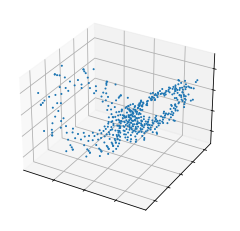

In [3]:
plotting.trajectories(X, style='o', lw=1, ms=1)

# Create random projections of state-space to scalar time series

In [4]:
n_obs = 5

x = []
for i in range(n_obs):
    x_tmp = time_series.random_projection(X, seed=i)
    x.append(x_tmp)

# Plot trajectories

(0.0, 5.0)

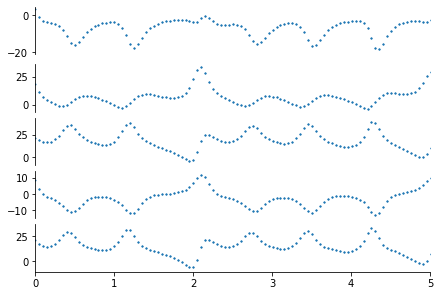

In [5]:
ax = plotting.time_series(T, x, style='o', figsize=(6,4), ms=1, save='Lorenz_projections.svg')
ax.set_xlim([0,5])

# Illustrate embedded attractors and neighbourhoods

In [6]:
from scipy.spatial.transform import Rotation as R
def circle(ax, r, X_p):
    
    theta = np.linspace(0, 2 * np.pi, 101)
    x = r*np.vstack([np.cos(theta), np.sin(theta), np.zeros_like(theta)]).T
    
    # ax.scatter(X_p[:,0],X_p[:,1],X_p[:,2],c='b')
    
    normal = np.cross((X_p[1]-X_p[0]), (X_p[2]-X_p[0]))
    # ax.scatter(normal[0],normal[1],normal[2],c='r')
    v_rot = np.cross(normal,[0,0,1])
    v_rot = np.divide(v_rot, np.sum(v_rot))
    # ax.scatter(v_rot[0],v_rot[1],v_rot[2],c='g')
    v_rot *= np.arccos(np.dot(v_rot, normal))
    M_R = R.from_rotvec(v_rot).as_matrix()
    x = np.matmul(M_R,x.T).T + X_p[0]
    
    ax.plot(x[:,0],x[:,1],x[:,2],'C1')
    
    return ax

Computing neighbours...: 100%|██████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.43it/s]


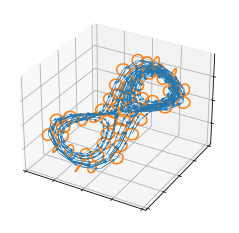

In [7]:
tau = -2
dim = 3
N=50
    
X_emb = time_series.delay_embed(X[:,0],dim,tau)
    
ind, _ = geometry.furthest_point_sampling(X_emb, N)
    
ax = plotting.trajectories(X_emb, style='->', lw=0.5, arrowhead=5, axis=False)

ind = np.array(list(set(ind)))
_, nn = time_series.find_nn(ind, X_emb, nn=2)
    
for i, nn_ in enumerate(nn):
    ax = circle(ax, 2, X_emb[[ind[i]] + list(nn_)])

<Axes3DSubplot:>

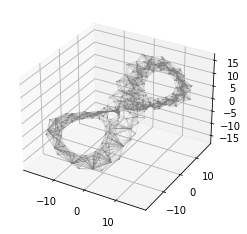

In [10]:
from torch_geometric.utils.convert import to_networkx
data = utils.construct_dataset(X_emb, graph_type='cknn', k=20)
G = to_networkx(data, node_attrs=['pos'], edge_attrs=None, to_undirected=True,
        remove_self_loops=True)
plotting.graph(G,labels=None,edge_alpha=0.3, edge_width=0.5)